In [43]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
rice_cammeo_and_osmancik = fetch_ucirepo(id=545) 
  
# data (as pandas dataframes) 
X = rice_cammeo_and_osmancik.data.features 
y = rice_cammeo_and_osmancik.data.targets 
  
y = (y == "Osmancik").astype(int)
print(X.head())
print(y.value_counts())

df = X.copy()
df["Class"] = y
print(df.head())
df["Class"].value_counts()

    Area   Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
0  15231  525.578979         229.749878          85.093788      0.928882   
1  14656  494.311005         206.020065          91.730972      0.895405   
2  14634  501.122009         214.106781          87.768288      0.912118   
3  13176  458.342987         193.337387          87.448395      0.891861   
4  14688  507.166992         211.743378          89.312454      0.906691   

   Convex_Area    Extent  
0        15617  0.572896  
1        15072  0.615436  
2        14954  0.693259  
3        13368  0.640669  
4        15262  0.646024  
Class
1        2180
0        1630
Name: count, dtype: int64
    Area   Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
0  15231  525.578979         229.749878          85.093788      0.928882   
1  14656  494.311005         206.020065          91.730972      0.895405   
2  14634  501.122009         214.106781          87.768288      0.912118   
3  13176  458.342

Class
1    2180
0    1630
Name: count, dtype: int64

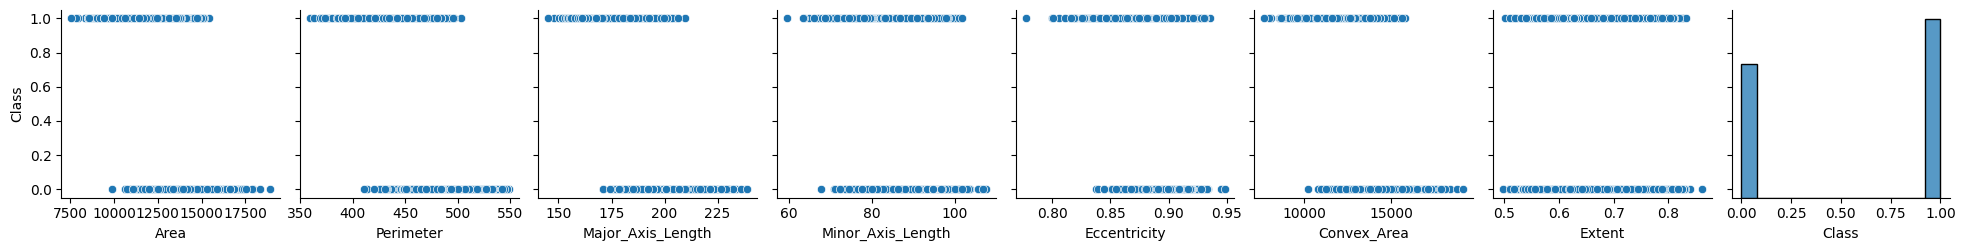

In [44]:
import seaborn as sns
sns.pairplot(data=df, y_vars=["Class"])

In [45]:
df.corr()["Class"].sort_values()

Major_Axis_Length   -0.827824
Perimeter           -0.806572
Convex_Area         -0.750424
Area                -0.746400
Eccentricity        -0.588916
Minor_Axis_Length   -0.370355
Extent               0.117727
Class                1.000000
Name: Class, dtype: float64

In [46]:
X = (X-X.mean()) / X.std() # normalize data 
X = X[["Area", "Perimeter", "Major_Axis_Length", "Convex_Area"]]
X.head()

,Area,Perimeter,Major_Axis_Length,Convex_Area
0,1.479635,2.004091,2.348238,1.499463
1,1.147720,1.125705,0.988261,1.192761
2,1.135020,1.317041,1.451718,1.126356
3,0.293398,0.115285,0.261405,0.233826
4,1.166191,1.486858,1.316269,1.299685


In [87]:
import numpy as np

class NeuralNetwork:
    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        f = self.sigmoid(z)
        return f * (1 - f)
    
    def __init__(self, num_inputs, layers = [], lr = 0.001):
        self.layers = layers # list of number of neurons per layer
        self.weights = []
        self.bias = []
        self.lr = lr

        for i, num_neurons in enumerate(layers):
           if i == 0:
               self.weights.append(np.random.randn(num_neurons, num_inputs)) # each row is an array of weights for a neuron
           else:
               previous_num_neurons = layers[i - 1]
               self.weights.append(np.random.randn(num_neurons, previous_num_neurons))
           self.bias.append(np.zeros(num_neurons))

    def feedforward(self, inputs):
        values = inputs
        activations = []
        sums = []
        sums.append(inputs)
        for i, layer in enumerate(self.layers):
            #v = []
            #sums.append([])
            weights = self.weights[i]
            biases = self.bias[i]
            #for j, row in enumerate(weights):
            #    s = np.dot(values, row) + biases[j]
            #    z = self.sigmoid(s)
            #    v.append(z)
            #    sums[-1].append(s)
            
            s = np.matmul(weights, values) + biases
            v = self.sigmoid(s)
            sums.append(s)
            
            values = v
            activations.append(values)
        return values, activations, sums

    def predict(self, inputs):
        return self.feedforward(inputs)[0]
    
    def loss(self, actual, predicted):
        loss = -(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))

    def loss_derivative(self, actual, predicted):
        D = -actual / predicted + (1 - actual) / (1 - predicted)
        return D
    
    def backpropagation(self, data, layer = -1):
        if layer == -1:
            inputs, label = data
            output, activations, sums = self.feedforward(inputs)
            output = output[0]
            # output layer can only have one neuron for now
            chain = self.loss_derivative(label, output) * self.sigmoid_derivative(sums[-1][0]) 
            for i, weight in enumerate(self.weights[-1][0]):
                self.weights[-1][0][i] = weight - self.lr * chain * activations[-2][i]
            self.bias[-1][0] = self.bias[-1][0] - self.lr * chain * 1

            self.backpropagation((chain, activations, sums), len(self.layers) - 2)
        else:
            for i in range(self.layers[layer]):
                chain, activations, sums = data
                new_chain = chain * self.weights[layer + 1][0][i] * self.sigmoid_derivative(sums[layer][i])
                for j, weight in enumerate(self.weights[layer][i]):
                    if layer > 0:
                        D = new_chain * activations[layer - 1][j]
                    else:
                        D = new_chain * sums[0][j]
                    self.weights[layer][i][j] = self.weights[layer][i][j] - self.lr * D
                self.bias[layer][i] = self.bias[layer][i] - self.lr * new_chain * 1
            new_chain = new_chain
            
            if layer >= 1:
                self.backpropagation((new_chain, activations, sums), layer - 1)

    def accuracy(self, data, labels):
        correct = 0
        n_rows = X_test.shape[0]
        for i in range(n_rows):
            row = data.iloc[i].to_numpy()
            label = labels.iloc[i].to_numpy()
            predicted = nn.predict(row)
            if np.round(predicted) == label:
                correct += 1
        return correct / n_rows


In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

nn = NeuralNetwork(4, layers=[3,1])
nn.lr = 0.00003

accuracy = []

for e in range(100):
    for i in range(X_train.shape[0]):
        row = X_train.iloc[i].to_numpy()
        label = y_train.iloc[i].to_numpy()
        nn.backpropagation((row, label))
    accuracy.append(nn.accuracy(X_train, y_train))

nn.weights

/var/folders/jl/7dg7lsrx3d941ctmwn5wlkvr0000gp/T/ipykernel_82460/3632093278.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.weights[-1][0][i] = weight - self.lr * chain * activations[-2][i]
/var/folders/jl/7dg7lsrx3d941ctmwn5wlkvr0000gp/T/ipykernel_82460/3632093278.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.bias[-1][0] = self.bias[-1][0] - self.lr * chain * 1
/var/folders/jl/7dg7lsrx3d941ctmwn5wlkvr0000gp/T/ipykernel_82460/3632093278.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

[array([[-0.62921004, -0.06997083, -1.4394495 ,  0.38762669],
        [ 1.57038218,  0.36616735,  0.70833501,  0.73428451],
        [-0.87172822,  0.34571013, -0.94137251,  0.48311003]]),
 array([[ 1.42150549, -1.89989815,  0.35334155]])]

<Axes: >

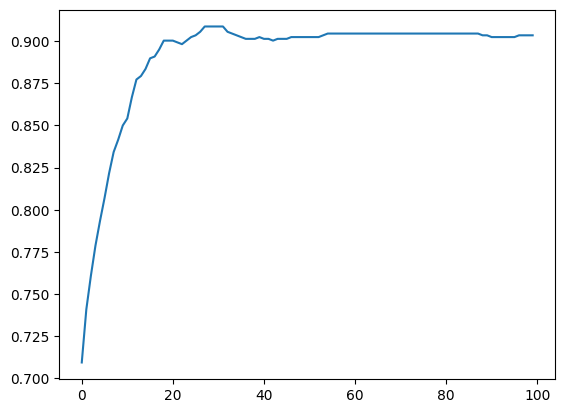

In [92]:
sns.lineplot(accuracy)

In [91]:
nn.accuracy(X_test, y_test)

0.9244491080797481